<a href="https://colab.research.google.com/github/SalhaAlzahrani/MS_Trust/blob/main/StatisticalTest_10_FoldCrossValidation_MY_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Statistical Test: Myelitis Classification
#### Step 1: 10-Fold Cross-Validation in Deep Learning for Myelitis Classification
#### Step 2: Paired t-test: If comparing two algorithms and the metric data is normally distributed, use the paired t-test to see if there’s a statistically significant difference between the two algorithms' performances.






In [ ]:
!pip install nest_asyncio
!pip install keras-cv

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras_cv

import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

import nest_asyncio

Mounted at /content/drive


# 🈺 Hyperparameters



In [ ]:
######################
NUM_CLASSES = 3
######################
positional_emb = True
conv_layers = 2
projection_dim = 128
num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1
learning_rate = 0.001
weight_decay = 0.0001
NUM_EPOCHS = 5
IMG_SIZE = 128
BATCH_SIZE = 32
input_shape = (IMG_SIZE, IMG_SIZE, 3)
np.random.seed(42)
tf.random.set_seed(42)
AUTO = tf.data.AUTOTUNE

In [ ]:
def preprocess_image(path):
    image = tf.keras.utils.load_img(path)
    image = tf.image.central_crop(image, central_fraction=0.9)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image

In [ ]:
path = '/content/drive/MyDrive/_MyResearch_/Myelitis_Dataset_Three_Classes/'
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
classes = np.array(classes)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 2771 files belonging to 3 classes.


{0: 0.6607057701478303, 1: 1.384807596201899, 2: 1.3083097261567516}

# 🅰 Augmentation Modules



In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix(alpha=0.02)
randaug = keras_cv.layers.RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.5)

def aug_pipeline1(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = cutmix(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = randaug(samples, training=True)
    return samples




---


# ⛓ MS-Trust (proposed)

The first recipe introduced by the CCT authors is the tokenizer for processing the images. In a standard ViT, images are organized into uniform non-overlapping patches. This eliminates the boundary-level information present in between different patches. This is important for a neural network to effectively exploit the locality information. The figure below presents an illustration of how images are organized into patches.

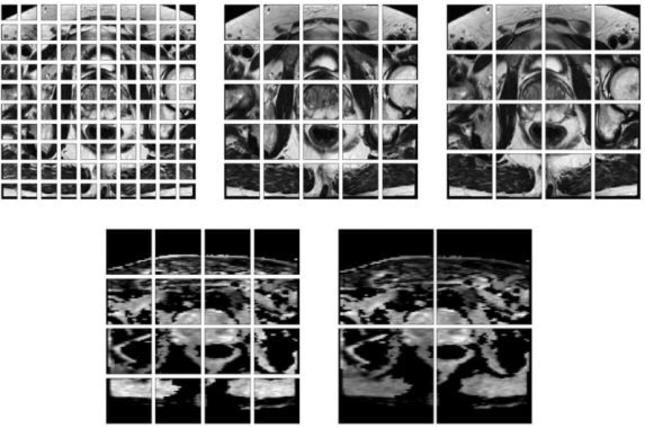

In [ ]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (keras.ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(
                shape, 0, 1, seed=self.seed_generator
            )
            random_tensor = keras.ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


In [ ]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = keras.ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = keras.ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return keras.ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
class SequencePooling(layers.Layer):
    def __init__(self):
        super().__init__()
        self.attention = layers.Dense(1)

    def call(self, x):
        attention_weights = keras.ops.softmax(self.attention(x), axis=1)
        attention_weights = keras.ops.transpose(attention_weights, axes=(0, 2, 1))
        weighted_representation = keras.ops.matmul(attention_weights, x)
        return keras.ops.squeeze(weighted_representation, -2)

In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = keras.ops.reshape(
            outputs,
            (
                -1,
                keras.ops.shape(outputs)[1] * keras.ops.shape(outputs)[2],
                keras.ops.shape(outputs)[-1],
            ),
        )
        return reshaped

## MLP for the Transformers encoder


In [ ]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in https://arxiv.org/abs/1709.01507.
    Args:         ratio: The ratio with which the feature map needs to be reduced in the reduction phase.
    Inputs:         Convolutional features.
    Outputs:        Attention modified feature maps.
    """
    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config
    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()
    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        SqueezeExcite(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Attention layers

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  """
  Base Attention layer class that contains a MultiHeadAttention, LayerNormalization and Add layer.
  """
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
  """
  A class that implements cross-attention mechanism by inheriting from BaseAttention class.
  Cross-attention is used to process two different sequences and attends to the context sequence while processing the query sequence.
  """
  def call(self, x, context):
    """
    The call function that performs the cross-attention operation.
    Args:
        x: The query sequence tensor, shape=(batch_size, seq_len, embedding_dim)
        context: The context sequence tensor, shape=(batch_size, seq_len, embedding_dim)
    Returns:
        The attended output tensor, shape=(batch_size, seq_len, embedding_dim)
    """
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    """
    Apply the global self-attention mechanism to the input sequence.
    Args:
        x: A tensor of shape `(batch_size, seq_len, embedding_dim)`
        representing the input sequence.
    Returns:
        A tensor of the same shape as the input, representing the sequence
        after being transformed by the self-attention mechanism.
    """
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class CausalSelfAttention(BaseAttention):
  """
  Call self attention on the input sequence, ensuring that each position in the
  output depends only on previous positions (i.e. a causal model).
  Args:
      x: Input sequence tensor of shape `(batch_size, seq_len, embed_dim)`.
  Returns:
      Output sequence tensor of the same shape as the input, after self-attention
      and residual connection with layer normalization applied.
  """
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## The final MS-Trust model



In [ ]:
def create_cct_model(
    image_size=IMG_SIZE,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        ###############################################################################
        # Layer normalization 1.
        x11 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
        # CausalSelfAttention
        attention_output = CausalSelfAttention(num_heads=num_heads, key_dim=projection_dim)(x11)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

        ###############################################################################
        # Layer normalization 1.
        x12 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
        # GlobalSelfAttention
        attention_output = GlobalSelfAttention(num_heads=num_heads, key_dim=projection_dim)(x12)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

        ###############################################################################
        # CrossAttention
        attention_output = CrossAttention(num_heads=num_heads, key_dim=projection_dim)(x11, x12)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])


    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)

    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_cct_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cct_tokenizer             │ (None, 1024, 128)      │         75,456 │ input_layer[0][0]      │
│ (CCTTokenizer)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding        │ (None, 1024, 128)      │        131,072 │ cct_tokenizer[0][0]    │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1024, 128)      │              0 │ cct_tokenizer[0][0],   │
│                           │                        │                │ position_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1024, 128)      │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ causal_self_attention     │ (None, 1024, 128)      │        132,224 │ layer_normalization[0… │
│ (CausalSelfAttention)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stochastic_depth          │ (None, 1024, 128)      │              0 │ causal_self_attention… │
│ (StochasticDepth)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1024, 128)      │              0 │ stochastic_depth[0][0… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 1024, 128)      │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024, 128)      │         16,512 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024, 128)      │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024, 128)      │         16,512 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024, 128)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stochastic_depth_1        │ (None, 1024, 128)      │              0 │ dropout_2[0][0]        │
│ (StochasticDepth)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 1024, 128)      │              0 │ stochastic_depth_1[0]… │
│                      

 Total params: 1,201,348 (4.58 MB)

 Trainable params: 1,201,348 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

# ⚛ 10-Fold Experiments

In [ ]:
from sklearn.model_selection import KFold
# Load dataset and extract file paths and labels
dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/_MyResearch_/Myelitis_Dataset_Three_Classes/",
    image_size=(IMG_SIZE, IMG_SIZE),
    label_mode='int',
    batch_size=32,
    #shuffle=True
)

# Extract file paths and labels from the dataset
file_paths = []
labels = []

for images, lbls in dataset.unbatch():
    file_paths.append(images.numpy())
    labels.append(lbls.numpy())

file_paths = np.array(file_paths)
labels = np.array(labels)

# Initialize KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)


Found 2771 files belonging to 3 classes.




---


# 🧠 10-Fold Cross-Validation: MS-Trust & MixUp (Myelitis)






In [ ]:
# Placeholder to store each fold's accuracy
fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths)):
    print(f"Training fold {fold+1}...")

    # Split data into training and validation based on indices
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create TensorFlow datasets from file paths and labels
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

    #train_ds_v = train_ds.map(to_dict)
    #train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    #train_ds_v = train_ds_v.batch(BATCH_SIZE) # Add batching here before prefetch
    #train_ds_v = train_ds_v.prefetch(tf.data.AUTOTUNE)

    #MixUp - Apply aug_pipeline1 AFTER batching
    mixup_ds = train_ds.shuffle(1000).map(to_dict)
    mixup_ds = mixup_ds.batch(BATCH_SIZE) # Batch first
    mixup_ds = mixup_ds.map(aug_pipeline1) # Apply augmentation after batching
    mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    mixup_ds = mixup_ds.prefetch(tf.data.AUTOTUNE) #Use this for fit

    val_ds_v = val_ds.map(to_dict)
    val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_v = val_ds_v.batch(BATCH_SIZE) # Add batching here before prefetch
    val_ds_v = val_ds_v.prefetch(tf.data.AUTOTUNE) #Use this for fit

    model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        keras.metrics.F1Score(average='macro'),
        ],
    )

    history = model.fit(mixup_ds,
                    class_weight=class_weights_dict,
                    epochs=NUM_EPOCHS)
    # Evaluate the model on the validation data for this fold
    evaluation_results = model.evaluate(val_ds_v)
    val_loss = evaluation_results[0]  # Loss is the first element
    val_accuracy = evaluation_results[1]  # Accuracy is the second element
    print(f"Fold {fold+1} Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)

Training fold 1...
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 114s 595ms/step - accuracy: 0.4491 - auc: 0.4891 - f1_score: 0.2961 - loss: 2.3329 - precision: 0.5238 - recall: 0.8471
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.2375 - auc: 0.5248 - f1_score: 0.1867 - loss: 1.0945 - precision: 0.5756 - recall: 0.2905
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.2837 - auc: 0.5067 - f1_score: 0.2209 - loss: 1.1531 - precision: 0.5426 - recall: 0.4022
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7038 - auc: 0.5349 - f1_score: 0.5365 - loss: 0.9318 - precision: 0.5352 - recall: 0.9910
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7151 - auc: 0.5976 - f1_score: 0.6144 - loss: 0.8773 - precision: 0.5638 - recall: 0.9763
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7531 - auc: 0.5201 - f1_score: 0.6651 - loss: 0.7495 - precision: 0.3333 - recall: 1.0000
Fold 1 Accuracy: 0.7842
Training fold 2...
Epoch 1/5
78/78 ━━━━━━━━

In [ ]:
fold_accuracies

[0.7841726541519165,
 0.7761732935905457,
 0.8231046795845032,
 0.8303248882293701,
 0.8736461997032166,
 0.8953068852424622,
 0.7942238450050354,
 0.8808664083480835,
 0.8989169597625732,
 0.8592057824134827]



---


# 🧠 10-Fold Cross-Validation: MS-Trust & CutMix (Myelitis)






In [ ]:
# Placeholder to store each fold's accuracy
fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths)):
    print(f"Training fold {fold+1}...")

    # Split data into training and validation based on indices
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create TensorFlow datasets from file paths and labels
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

    #CutMix - Apply aug_pipeline2 AFTER batching
    cutmix_ds = train_ds.shuffle(1000).map(to_dict)
    cutmix_ds = cutmix_ds.batch(BATCH_SIZE) # Batch first
    cutmix_ds = cutmix_ds.map(aug_pipeline2) # Apply augmentation after batching
    cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    cutmix_ds = cutmix_ds.prefetch(tf.data.AUTOTUNE) #Use this for fit

    val_ds_v = val_ds.map(to_dict)
    val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_v = val_ds_v.batch(BATCH_SIZE) # Add batching here before prefetch
    val_ds_v = val_ds_v.prefetch(tf.data.AUTOTUNE) #Use this for fit

    model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        keras.metrics.F1Score(average='macro'),
        ],
    )

    history = model.fit(cutmix_ds,
                    class_weight=class_weights_dict,
                    epochs=NUM_EPOCHS)
    # Evaluate the model on the validation data for this fold
    evaluation_results = model.evaluate(val_ds_v)
    val_loss = evaluation_results[0]  # Loss is the first element
    val_accuracy = evaluation_results[1]  # Accuracy is the second element
    print(f"Fold {fold+1} Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)

Training fold 1...
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 75s 367ms/step - accuracy: 0.7660 - auc_22: 0.5285 - f1_score: 0.7431 - loss: 0.7489 - precision_22: 0.3959 - recall_22: 0.9995
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7940 - auc_22: 0.5419 - f1_score: 0.7838 - loss: 0.7015 - precision_22: 0.3938 - recall_22: 0.9979
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7945 - auc_22: 0.5498 - f1_score: 0.7798 - loss: 0.6869 - precision_22: 0.3930 - recall_22: 0.9991
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8160 - auc_22: 0.5306 - f1_score: 0.7953 - loss: 0.6503 - precision_22: 0.3910 - recall_22: 0.9981
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8082 - auc_22: 0.5621 - f1_score: 0.7903 - loss: 0.6597 - precision_22: 0.3969 - recall_22: 0.9989
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step - accuracy: 0.9178 - auc_22: 0.6528 - f1_score: 0.9012 - loss: 0.4423 - precision_22: 0.3591 - recall_22: 1.0000
Fold 1 Accur

In [ ]:
fold_accuracies

[0.9496402740478516,
 0.916967511177063,
 0.9422382712364197,
 0.9602888226509094,
 0.9638988971710205,
 0.9458483457565308,
 0.9386281371116638,
 0.9638988971710205,
 0.9530686140060425,
 0.9602888226509094]



---
# ⚫ 10-Fold Cross-Validation: MS-Trust & RandAug (Myelitis)


In [ ]:
# Placeholder to store each fold's accuracy
fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths)):
    print(f"Training fold {fold+1}...")

    # Split data into training and validation based on indices
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create TensorFlow datasets from file paths and labels
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

    #RandAug - Apply aug_pipeline3 AFTER batching
    randaug_ds = train_ds.shuffle(1000).map(to_dict)
    randaug_ds = randaug_ds.batch(BATCH_SIZE) # Batch first
    randaug_ds = randaug_ds.map(aug_pipeline3) # Apply augmentation after batching
    randaug_ds = randaug_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    randaug_ds = randaug_ds.prefetch(tf.data.AUTOTUNE) #Use this for fit

    val_ds_v = val_ds.map(to_dict)
    val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_v = val_ds_v.batch(BATCH_SIZE) # Add batching here before prefetch
    val_ds_v = val_ds_v.prefetch(tf.data.AUTOTUNE) #Use this for fit

    model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        keras.metrics.F1Score(average='macro'),
        ],
    )

    history = model.fit(randaug_ds,
                    class_weight=class_weights_dict,
                    epochs=NUM_EPOCHS)
    # Evaluate the model on the validation data for this fold
    evaluation_results = model.evaluate(val_ds_v)
    val_loss = evaluation_results[0]  # Loss is the first element
    val_accuracy = evaluation_results[1]  # Accuracy is the second element
    print(f"Fold {fold+1} Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)

Training fold 1...
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 78s 429ms/step - accuracy: 0.6607 - auc_32: 0.5237 - f1_score: 0.6265 - loss: 0.8986 - precision_32: 0.3357 - recall_32: 0.9980
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.7201 - auc_32: 0.5563 - f1_score: 0.6751 - loss: 0.7948 - precision_32: 0.3384 - recall_32: 0.9980
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.7354 - auc_32: 0.5380 - f1_score: 0.6846 - loss: 0.7925 - precision_32: 0.3364 - recall_32: 0.9999
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.7672 - auc_32: 0.5686 - f1_score: 0.7265 - loss: 0.7380 - precision_32: 0.3402 - recall_32: 0.9998
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.7602 - auc_32: 0.5576 - f1_score: 0.7093 - loss: 0.7386 - precision_32: 0.3391 - recall_32: 0.9990
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - accuracy: 0.8719 - auc_32: 0.6721 - f1_score: 0.8406 - loss: 0.5246 - precision_32: 0.3625 - recall_32: 1.0000
Fold

In [ ]:
fold_accuracies

[0.8956834673881531,
 0.8086642622947693,
 0.8555956482887268,
 0.8880866169929504,
 0.8736461997032166,
 0.9133573770523071,
 0.8808664083480835,
 0.8664259910583496,
 0.8989169597625732,
 0.8880866169929504]



---



# ⚫ 10-Fold Cross Validation: CCT (Myelitis)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_cct_model(
    image_size=IMG_SIZE,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])


    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)

    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model_cct = create_cct_model()
model_cct.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cct_tokenizer_4           │ (None, 1024, 128)      │         75,456 │ input_layer_8[0][0]    │
│ (CCTTokenizer)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding_4      │ (None, 1024, 128)      │        131,072 │ cct_tokenizer_4[0][0]  │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 1024, 128)      │              0 │ cct_tokenizer_4[0][0], │
│                           │                        │                │ position_embedding_4[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_17    │ (None, 1024, 128)      │            256 │ add_17[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 1024, 128)      │        131,968 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stochastic_depth_13       │ (None, 1024, 128)      │              0 │ multi_head_attention_… │
│ (StochasticDepth)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 1024, 128)      │              0 │ stochastic_depth_13[0… │
│                           │                        │                │ add_17[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_18    │ (None, 1024, 128)      │            256 │ add_18[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 1024, 128)      │         16,512 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 1024, 128)      │              0 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 1024, 128)      │         16,512 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 1024, 128)      │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stochastic_depth_14       │ (None, 1024, 128)      │              0 │ dropout_21[0][0]       │
│ (StochasticDepth)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)         

 Total params: 538,308 (2.05 MB)

 Trainable params: 538,308 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

## RandAug

In [ ]:
# Placeholder to store each fold's accuracy
fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths)):
    print(f"Training fold {fold+1}...")

    # Split data into training and validation based on indices
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create TensorFlow datasets from file paths and labels
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

    #RandAug - Apply aug_pipeline3 AFTER batching
    randaug_ds = train_ds.shuffle(1000).map(to_dict)
    randaug_ds = randaug_ds.batch(BATCH_SIZE) # Batch first
    randaug_ds = randaug_ds.map(aug_pipeline3) # Apply augmentation after batching
    randaug_ds = randaug_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    randaug_ds = randaug_ds.prefetch(tf.data.AUTOTUNE) #Use this for fit

    val_ds_v = val_ds.map(to_dict)
    val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_v = val_ds_v.batch(BATCH_SIZE) # Add batching here before prefetch
    val_ds_v = val_ds_v.prefetch(tf.data.AUTOTUNE) #Use this for fit

    model_cct.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        keras.metrics.F1Score(average='macro'),
        ],
    )

    history = model_cct.fit(randaug_ds,
                    class_weight=class_weights_dict,
                    epochs=NUM_EPOCHS)
    # Evaluate the model on the validation data for this fold
    evaluation_results = model_cct.evaluate(val_ds_v)
    val_loss = evaluation_results[0]  # Loss is the first element
    val_accuracy = evaluation_results[1]  # Accuracy is the second element
    print(f"Fold {fold+1} Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)

Training fold 1...
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 79s 429ms/step - accuracy: 0.3913 - auc: 0.4959 - f1_score: 0.3478 - loss: 1.7869 - precision: 0.3319 - recall: 0.9058
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.5198 - auc: 0.5255 - f1_score: 0.4214 - loss: 1.0217 - precision: 0.3407 - recall: 0.9994
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.6062 - auc: 0.6169 - f1_score: 0.5307 - loss: 1.7874 - precision: 0.3808 - recall: 0.9817
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.2825 - auc: 0.5004 - f1_score: 0.1730 - loss: 1.1181 - precision: 0.3335 - recall: 1.0000
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.4403 - auc: 0.5002 - f1_score: 0.4201 - loss: 1.0844 - precision: 0.3334 - recall: 1.0000
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3295 - auc: 0.5000 - f1_score: 0.3149 - loss: 1.0965 - precision: 0.3333 - recall: 1.0000
Fold 1 Accuracy: 0.3345
Training fold 2...
Epoch 1/5
78/78 ━━━━━━━━

In [ ]:
fold_accuracies

[0.33453238010406494,
 0.28158843517303467,
 0.3140794336795807,
 0.02527075819671154,
 0.007220216561108828,
 0.010830325074493885,
 0.036101084202528,
 0.02527075819671154,
 0.02166065014898777,
 0.007220216561108828]

In [ ]:
del model_cct, history

## MixUp

In [ ]:
# Placeholder to store each fold's accuracy
fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths)):
    print(f"Training fold {fold+1}...")

    # Split data into training and validation based on indices
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create TensorFlow datasets from file paths and labels
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

    #MixUp - Apply aug_pipeline1 AFTER batching
    mixup_ds = train_ds.shuffle(1000).map(to_dict)
    mixup_ds = mixup_ds.batch(BATCH_SIZE) # Batch first
    mixup_ds = mixup_ds.map(aug_pipeline1) # Apply augmentation after batching
    mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    mixup_ds = mixup_ds.prefetch(tf.data.AUTOTUNE) #Use this for fit

    val_ds_v = val_ds.map(to_dict)
    val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_v = val_ds_v.batch(BATCH_SIZE) # Add batching here before prefetch
    val_ds_v = val_ds_v.prefetch(tf.data.AUTOTUNE) #Use this for fit

    model_cct.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        keras.metrics.F1Score(average='macro'),
        ],
    )

    history = model_cct.fit(mixup_ds,
                    class_weight=class_weights_dict,
                    epochs=NUM_EPOCHS)
    # Evaluate the model on the validation data for this fold
    evaluation_results = model_cct.evaluate(val_ds_v)
    val_loss = evaluation_results[0]  # Loss is the first element
    val_accuracy = evaluation_results[1]  # Accuracy is the second element
    print(f"Fold {fold+1} Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)

Training fold 1...
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - accuracy: 0.5025 - auc_10: 0.6541 - f1_score: 0.2403 - loss: 7.6430 - precision_10: 0.7424 - recall_10: 0.4567
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4807 - auc_10: 0.6438 - f1_score: 0.2164 - loss: 11.0001 - precision_10: 0.7403 - recall_10: 0.4699
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4963 - auc_10: 0.6369 - f1_score: 0.2222 - loss: 10.6058 - precision_10: 0.7298 - recall_10: 0.4634
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4846 - auc_10: 0.6244 - f1_score: 0.2176 - loss: 10.9133 - precision_10: 0.7187 - recall_10: 0.4495
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5159 - auc_10: 0.6497 - f1_score: 0.2269 - loss: 10.2540 - precision_10: 0.7520 - recall_10: 0.4748
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - accuracy: 0.4926 - auc_10: 0.6195 - f1_score: 0.2196 - loss: 8.4349 - precision_10: 0.4926 - recall_10: 0.4926
Fold 1 A

In [ ]:
fold_accuracies

[0.5179855823516846,
 0.5090252757072449,
 0.4909747242927551,
 0.4945848286151886,
 0.5018050670623779,
 0.512635350227356,
 0.5270758271217346,
 0.5018050670623779,
 0.5379061102867126,
 0.45126354694366455]

In [ ]:
del model_cct, history

## CutMix

In [ ]:
# Placeholder to store each fold's accuracy
fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths)):
    print(f"Training fold {fold+1}...")

    # Split data into training and validation based on indices
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create TensorFlow datasets from file paths and labels
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

    #CutMix - Apply aug_pipeline2 AFTER batching
    cutmix_ds = train_ds.shuffle(1000).map(to_dict)
    cutmix_ds = cutmix_ds.batch(BATCH_SIZE) # Batch first
    cutmix_ds = cutmix_ds.map(aug_pipeline2) # Apply augmentation after batching
    cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    cutmix_ds = cutmix_ds.prefetch(tf.data.AUTOTUNE) #Use this for fit

    val_ds_v = val_ds.map(to_dict)
    val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_v = val_ds_v.batch(BATCH_SIZE) # Add batching here before prefetch
    val_ds_v = val_ds_v.prefetch(tf.data.AUTOTUNE) #Use this for fit

    model_cct.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        keras.metrics.F1Score(average='macro'),
        ],
    )

    history = model_cct.fit(cutmix_ds,
                    class_weight=class_weights_dict,
                    epochs=NUM_EPOCHS)
    # Evaluate the model on the validation data for this fold
    evaluation_results = model_cct.evaluate(val_ds_v)
    val_loss = evaluation_results[0]  # Loss is the first element
    val_accuracy = evaluation_results[1]  # Accuracy is the second element
    print(f"Fold {fold+1} Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)

Training fold 1...
Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 31s 164ms/step - accuracy: 0.2837 - auc_20: 0.4042 - f1_score: 0.2470 - loss: 7.4302 - precision_20: 0.2997 - recall_20: 0.4068
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2502 - auc_20: 0.4379 - f1_score: 0.1358 - loss: 7.8613 - precision_20: 0.2951 - recall_20: 0.2291
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2340 - auc_20: 0.4404 - f1_score: 0.1434 - loss: 9.2833 - precision_20: 0.2956 - recall_20: 0.2272
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2589 - auc_20: 0.4462 - f1_score: 0.1592 - loss: 9.0685 - precision_20: 0.2989 - recall_20: 0.2351
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3194 - auc_20: 0.4762 - f1_score: 0.2414 - loss: 4.3397 - precision_20: 0.3646 - recall_20: 0.6604
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step - accuracy: 0.4926 - auc_20: 0.4993 - f1_score: 0.2196 - loss: 1.0509 - precision_20: 0.3331 - recall_20: 0.8382
Fold 1 Accur

In [ ]:
fold_accuracies

[0.5179855823516846,
 0.7111913561820984,
 0.7581227421760559,
 0.23104692995548248,
 0.7942238450050354,
 0.8628158569335938,
 0.8231046795845032,
 0.826714813709259,
 0.8628158569335938,
 0.833935022354126]



---

